# Bayesian vector autoregression baseline

In [1]:
from utils import *

## Load the data

In [2]:
raw_data = pd.read_csv("fred_md.csv").iloc[1:, :]

raw_data["sasdate"] = pd.to_datetime(raw_data["sasdate"], format="%m/%d/%Y")
raw_data.index = raw_data["sasdate"]

raw_data.head()

sasdate      RPI  W875RX1  DPCERA3M086SBEA  CMRMTSPLx   RETAILx  \
sasdate                                                                         
1959-01-01 1959-01-01 2442.158 2293.200           17.272 292266.426 18235.774   
1959-02-01 1959-02-01 2451.778 2301.500           17.452 294424.742 18369.563   
1959-03-01 1959-03-01 2467.594 2318.500           17.617 293418.670 18523.058   
1959-04-01 1959-04-01 2483.671 2334.900           17.553 299322.804 18534.466   
1959-05-01 1959-05-01 2498.026 2350.400           17.765 301364.325 18679.664   

            INDPRO  IPFPNSS  IPFINAL  IPCONGD  IPDCONGD  IPNCONGD  IPBUSEQ  \
sasdate                                                                      
1959-01-01  22.015   23.398   22.285   31.585    18.686    38.150    8.148   
1959-02-01  22.446   23.714   22.478   31.816    18.784    38.515    8.257   
1959-03-01  22.770   23.858   22.588   31.816    19.152    38.333    8.346   
1959-04-01  23.255   24.202   22.919   32.318    19.275    38.971    8.565   
1959-05-01  23.605   24.403   23.140   32.473    19.667    38.971    8.842   

            IPMAT  IPDMAT  IPNMAT  IPMANSICS  IPB51222S  IPFUELS  CUMFNS  \
sasdate                                                                    
1959-01-01 20.131  12.139  30.652     20.896     19.918   34.670  80.197   
1959-02-01 20.769  12.698  31.189     21.280     19.863   34.198  81.443   
1959-03-01 21.308  13.198  31.657     21.613     19.999   35.064  82.477   
1959-04-01 21.897  13.595  32.638     22.074     20.080   34.906  83.992   
1959-05-01 22.461  14.066  32.931     22.381     20.378   34.237  84.916   

                HWI  HWIURATIO   CLF16OV    CE16OV  UNRATE  UEMPMEAN  UEMPLT5  \
sasdate                                                                         
1959-01-01 1357.000      0.334 67936.000 63868.000   6.000    16.300 1574.000   
1959-02-01 1421.000      0.358 67649.000 63684.000   5.900    15.500 1554.000   
1959-03-01 1524.000      0.401 68068.000 64267.000   5.600    15.300 1459.000   
1959-04-01 1589.000      0.445 68339.000 64768.000   5.200    14.900 1494.000   
1959-05-01 1655.000      0.476 68178.000 64699.000   5.100    14.700 1479.000   

            UEMP5TO14  UEMP15OV  UEMP15T26  UEMP27OV    CLAIMSx    PAYEMS  \
sasdate                                                                     
1959-01-01   1169.000  1396.000    594.000   802.000 291078.000 52478.000   
1959-02-01   1164.000  1277.000    545.000   732.000 282958.000 52688.000   
1959-03-01   1093.000  1210.000    530.000   680.000 260346.000 53014.000   
1959-04-01    934.000  1039.000    408.000   631.000 246413.000 53321.000   
1959-05-01   1005.000   965.000    390.000   575.000 246952.000 53550.000   

              USGOOD  CES1021000001   USCONS    MANEMP  DMANEMP  NDMANEMP  \
sasdate                                                                     
1959-01-01 18796.000        713.000 2993.000 14998.000 8740.000  6258.000   
1959-02-01 18890.000        704.200 2980.000 15115.000 8839.000  6276.000   
1959-03-01 19069.000        704.100 3013.000 15259.000 8965.000  6294.000   
1959-04-01 19269.000        705.200 3085.000 15385.000 9077.000  6308.000   
1959-05-01 19378.000        710.000 3087.000 15487.000 9160.000  6327.000   

              SRVPRD     USTPU  USWTRADE  USTRADE   USFIRE   USGOVT  \
sasdate                                                               
1959-01-01 33682.000 10774.000  2568.700 5350.300 2418.000 8105.000   
1959-02-01 33798.000 10816.000  2575.400 5381.300 2420.000 8116.000   
1959-03-01 33945.000 10873.000  2584.400 5431.600 2430.000 8132.000   
1959-04-01 34052.000 10905.000  2596.900 5395.400 2439.000 8142.000   
1959-05-01 34172.000 10949.000  2607.400 5456.300 2447.000 8153.000   

            CES0600000007  AWOTMAN  AWHMAN    HOUST  HOUSTNE  HOUSTMW  HOUSTS  \
sasdate                                                                         
1959-01-01         39.800    2.500  40.200 1657.000  350.0

## Data preprocessing

In [3]:
full_data = raw_data[list(features_to_names.keys())].copy()
for f, transf in feat_to_transform.items():
    full_data[f] = transf(full_data[f])
full_data = full_data.rename(columns=features_to_names)

while pd.isnull(full_data["real_income"].iloc[-1]):
    full_data = full_data.iloc[:-1, :]
while pd.isnull(full_data["real_income"].iloc[0]):
    full_data = full_data.iloc[1:, :]
    
data = full_data[full_data.index < "2019-01-01"]

## Simple 1 month BVAR prediction

**Some useful resources**
- Introduction to the BVAR http://joshuachan.org/papers/large_BVAR.pdf
- Look at the R packages for Bayesian training https://github.com/nk027/bvar, with paper provided https://core.ac.uk/download/pdf/237194683.pdf and documentation https://cran.r-project.org/web/packages/BVAR/BVAR.pdf
- RPY2 documentation https://rpy2.github.io/doc/latest/html/introduction.html

In [4]:
# # The code below is needed only for the first run to install necessary libraries
# # import rpy2's package module
# import rpy2.robjects.packages as rpackages

# # import R's utility package
# utils = rpackages.importr('utils')

# # select a mirror for R packages
# utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# # install a package
# utils.install_packages("BVAR")

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from rpy2.robjects.packages import importr
from rpy2 import robjects
from rpy2.robjects import pandas2ri

r = robjects.r
bvar = importr('BVAR')

with (robjects.default_converter + pandas2ri.converter).context():
    r_data = robjects.conversion.get_conversion().py2rpy(data)

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def run_bvar_cv(df, init_rows_train, p, priors=None):
    results = dict(zip(df.columns, [[] for _ in range(len(df.columns))]))
    
    # Convert preprocessed Pandas dataframe to R one
    with (robjects.default_converter + pandas2ri.converter).context():
        r_df = robjects.conversion.get_conversion().py2rpy(df)

    for train_end_ind in tqdm(range(init_rows_train, len(df))):
        train = df.iloc[0:train_end_ind]
        r_X_train = r_df.head(train_end_ind)
        test = df.iloc[train_end_ind]
        
        if priors:
            model = bvar.bvar(r_X_train, lags=p, n_draw=1000, n_burn=400, verbose=False, priors=priors)
        else:
            model = bvar.bvar(r_X_train, lags=p, n_draw=1000, n_burn=400, verbose=False)
        
        # Predicting next observation based on last train p observations
        test_forecast = bvar.predict_bvar(model, horizon=1, conf_bands=0.5)
        all_X_test_pred = robjects.numpy2ri.rpy2py_floatvector(test_forecast[0])
        X_test_pred = np.median(all_X_test_pred, axis=0)
        
        # Predicting the last train observation by taking p but the last observations
        train_forecast = bvar.predict_bvar(model, horizon=1, conf_bands=0.5, newdata=r_X_train.head(-1))
        all_X_train_pred = robjects.numpy2ri.rpy2py_floatvector(train_forecast[0])
        X_train_pred = np.median(all_X_train_pred, axis=0)
        
        for i, f in enumerate(df.columns):
            results[f].append({"last_train_date": train.iloc[-1].name,
                          "last_train": train[f].iloc[-1],
                          "test_date": test.name,
                          "test": test[f],
                          "train_pred": X_train_pred[0][i],
                          "test_pred": X_test_pred[0][i]})

    for f in df.columns:
        results[f] = pd.DataFrame(results[f])
        
    return results

### Model sanity checks

- Read and adjust manually the following parameters, because otherwise the algorithms fails to estimate them automatically.
    - bv_lambda(): Tightness of the Minnesota prior
    - bv_alpha(): Variance decay with increasing lag order
    - bv_psi(): Prior standard deviation on other lag
- Tune the model hyperparameters given a one year window period for metric aggregation. Choose appropriate number of lags(p) and prior distribution of coefficients.

In [7]:
# Training the model on some random sample of the data and create a default psi parameter
# Which will prevent our model from giving warnings about default psi
p = 6
model = bvar.bvar(r_data.head(12 * 60), lags=p, n_draw=1000, n_burn=400, verbose=False)
default_psi = model[5][3]

In [8]:
# Set the priors for BVAR model
minnesota_params = bvar.bv_minnesota(
    bvar.bv_lambda(mode = 0.2, sd = 0.4, min = 0.0001, max = 5),
    bvar.bv_alpha(mode = 2, sd = 0.25, min = 1, max = 3),
    default_psi
    #bvar.bv_psi(scale = 0.004, shape = 0.004, mode = "auto", min = "auto", max = "auto")
)
priors = bvar.bv_priors(mn=minnesota_params)

In [13]:
p = 2
r_X_train = r_data.head(12 * 59)
model = bvar.bvar(r_X_train, lags=p, n_draw=1000, n_burn=400, verbose=False, priors=priors)

### Tuning the number of lags in the model

In [9]:
init_rows_train = 12 * 50
ps = list(range(1, 10))
metric = mean_squared_error

p_results = []
for p in tqdm(ps):
    res = run_bvar_cv(data, init_rows_train, p, priors)
    for f in data.columns:
        p_results.append({
            "p" : p,
            "feature": f,
            "var_train_result": metric(res[f]["last_train"], res[f]["train_pred"]),
            "var_test_result": metric(res[f]["test"], res[f]["test_pred"])
        })
p_results = pd.DataFrame(p_results)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

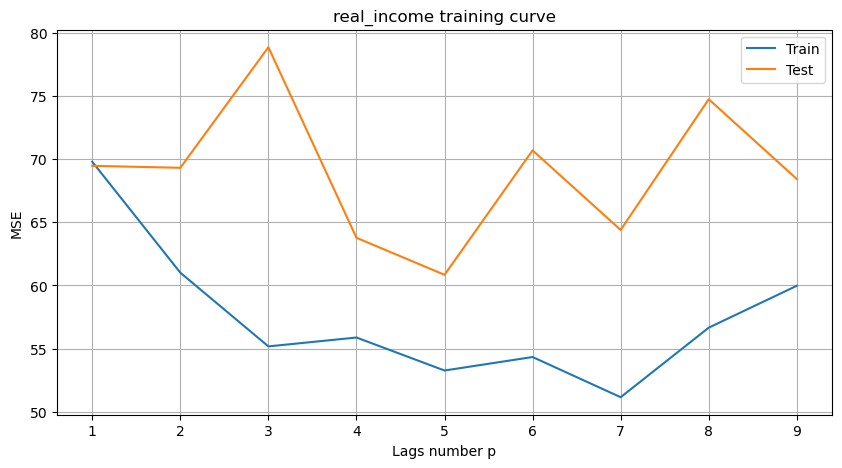

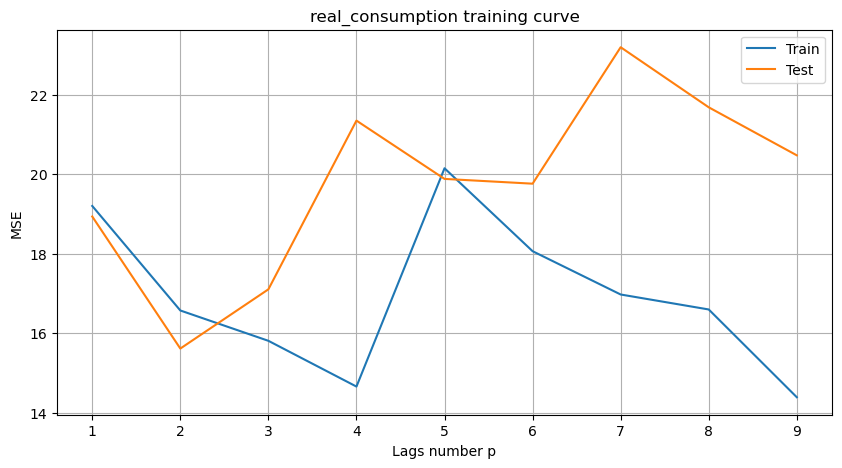

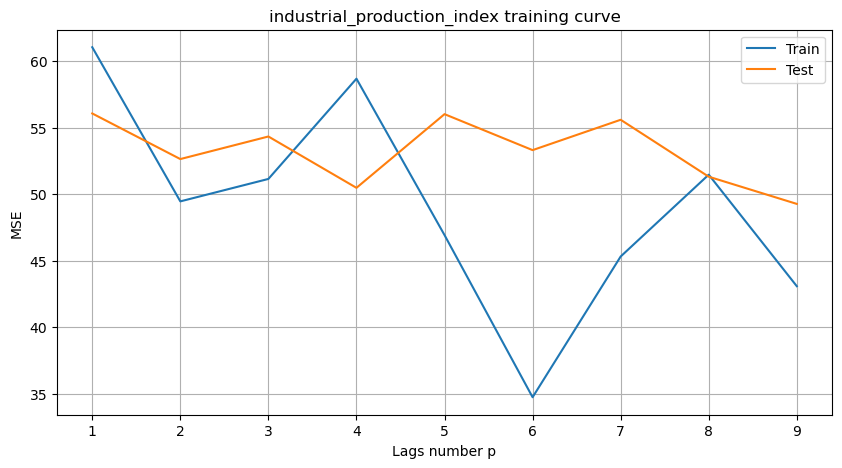

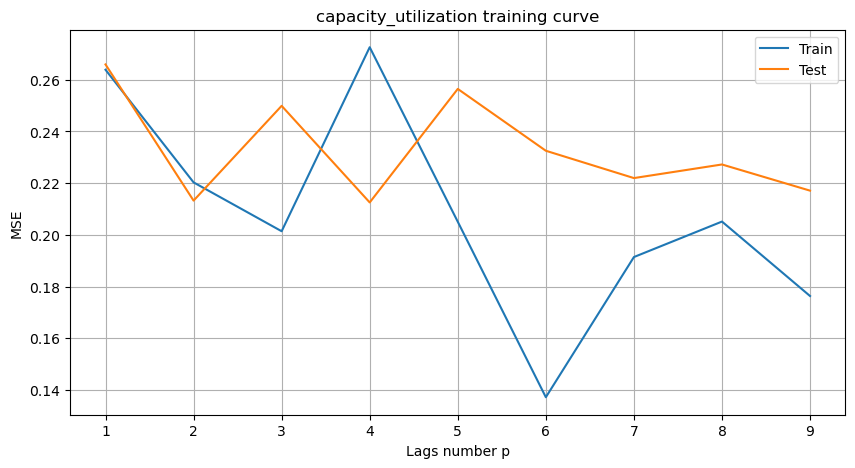

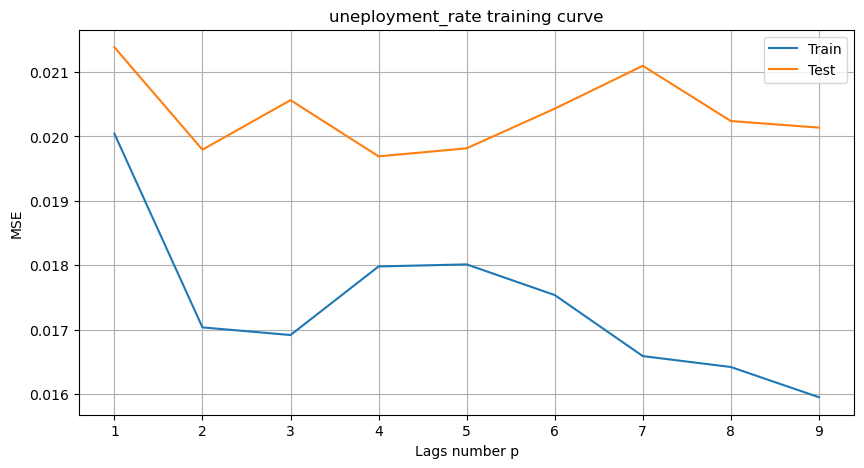

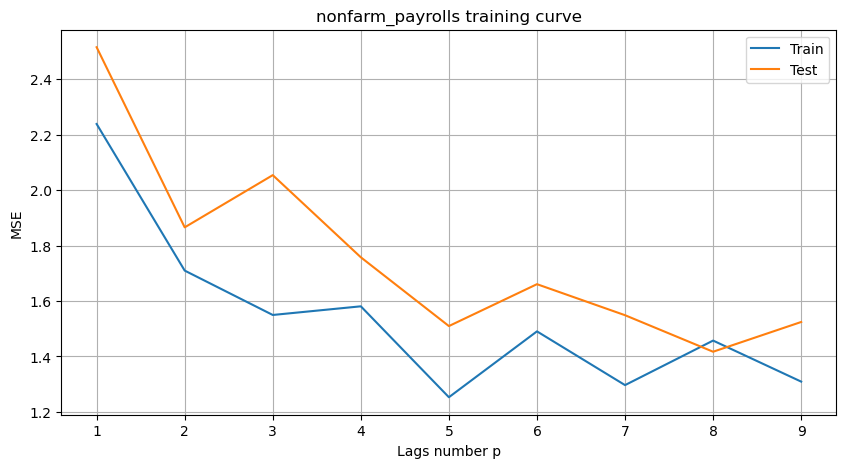

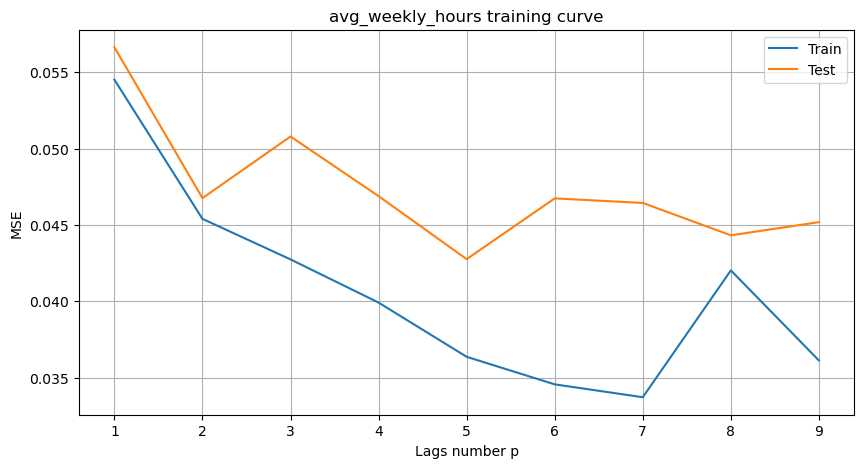

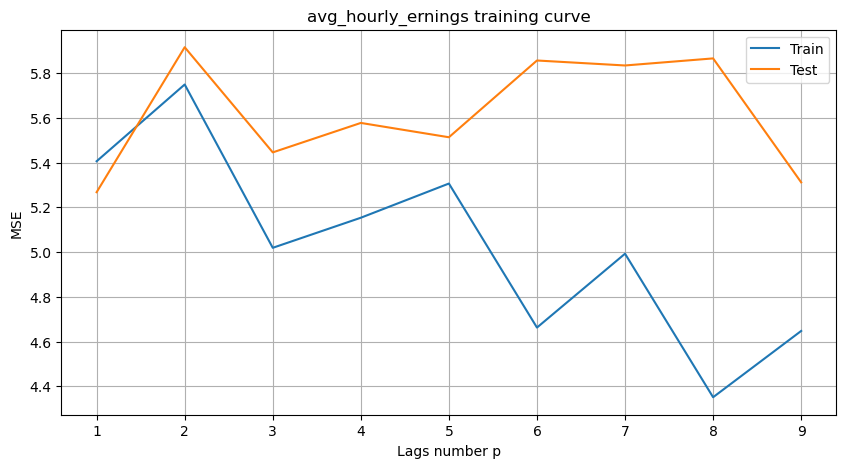

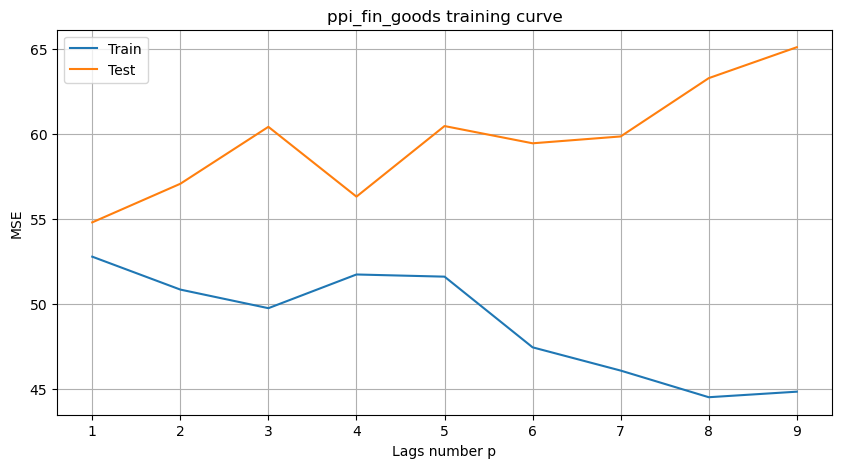

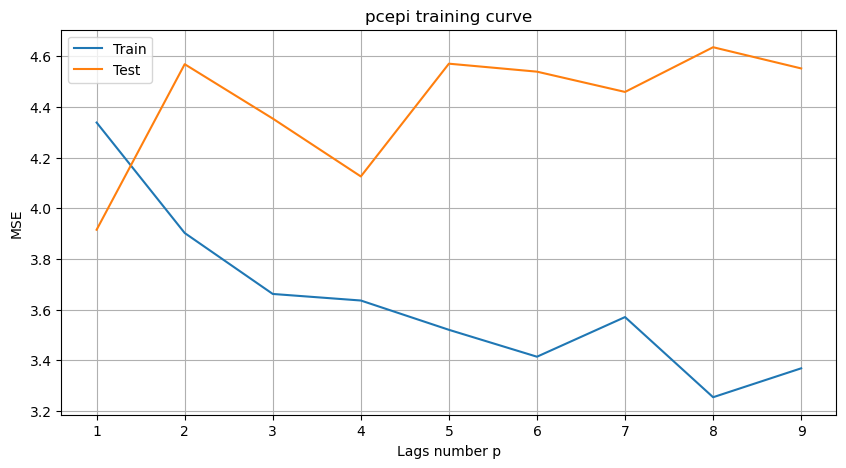

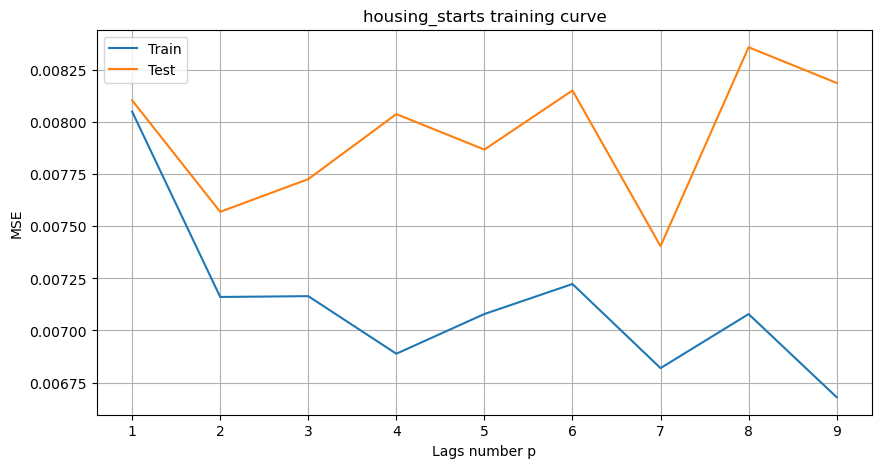

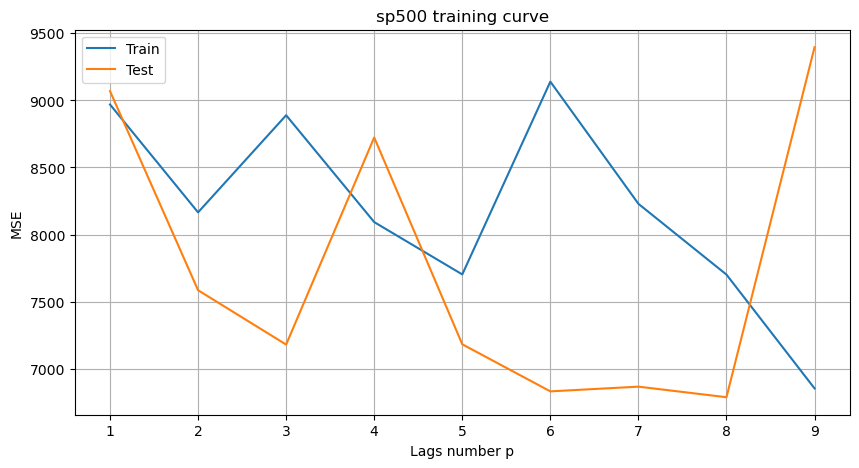

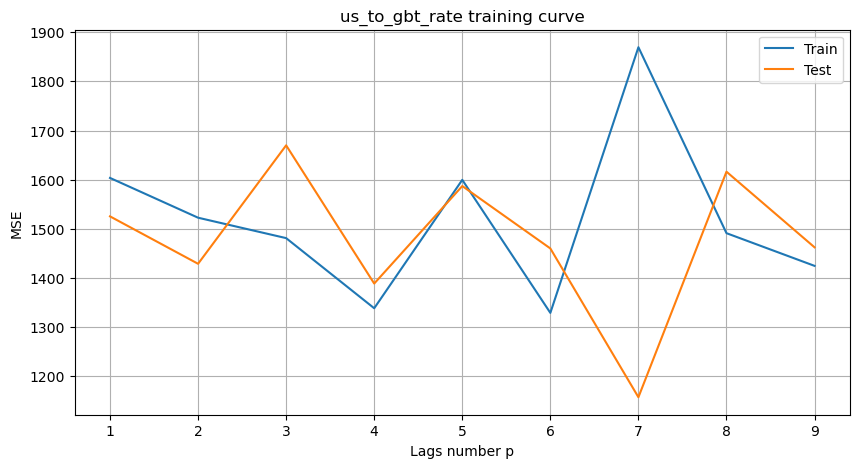

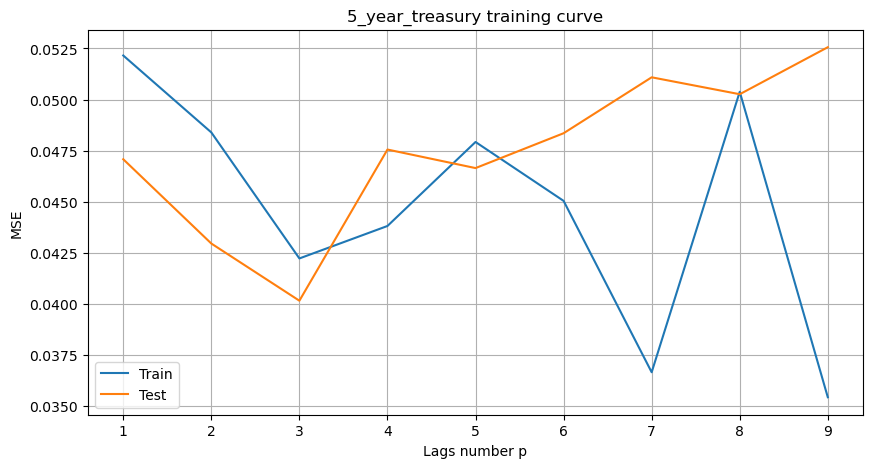

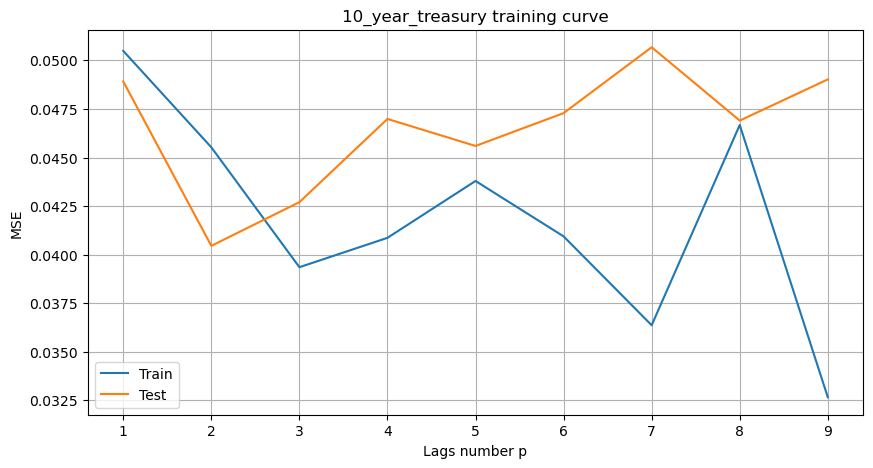

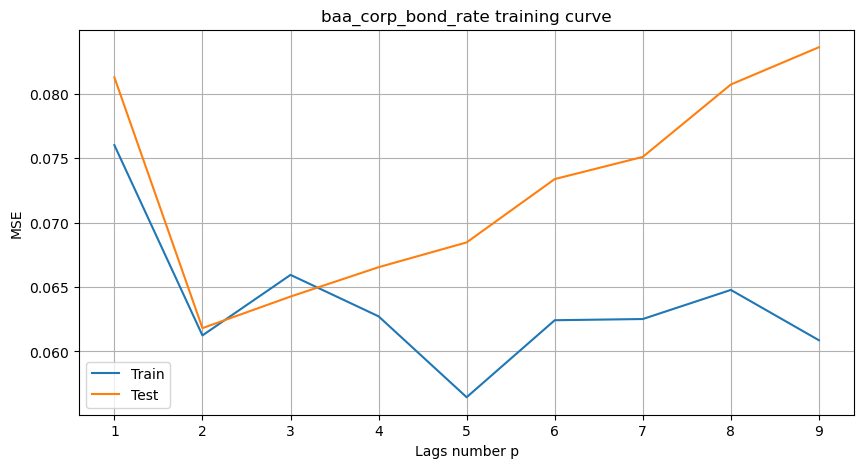

In [10]:
for f in data.columns:
    res = p_results[p_results["feature"] == f].sort_values("p")
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.grid()
    sns.lineplot(x=ps, y=res["var_train_result"], label="Train")
    sns.lineplot(x=ps, y=res["var_test_result"], label="Test")
    plt.xlabel("Lags number p")
    plt.ylabel("MSE")
    plt.title(f"{f} training curve")

## Analyzing the best results

In [11]:
init_rows_train = 12 * 40
p = 2

results = run_bvar_cv(data, init_rows_train, p, priors=priors)

  0%|          | 0/239 [00:00<?, ?it/s]

In [12]:
metrics = {
    "mse": mean_squared_error,
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error
}

metric_df = []
for f in data.columns:
    for m in metrics:
        metric_df.append({"feature": f, 
                          "metric": m,
                          "var_train_result": metrics[m](results[f]["last_train"], results[f]["train_pred"]),
                          "var_test_result": metrics[m](results[f]["test"], results[f]["test_pred"]), 
                          "const_test_result": metrics[m](results[f]["test"], results[f]["last_train"])})
metric_df = pd.DataFrame(metric_df)

In [13]:
# p = 2
metric_df[metric_df["metric"] == "mse"]

feature metric  var_train_result  var_test_result  \
0                   real_income    mse            60.851           72.708   
3              real_consumption    mse            26.235           25.666   
6   industrial_production_index    mse            68.290           76.701   
9          capacity_utilization    mse             0.291            0.285   
12             uneployment_rate    mse             0.016            0.018   
15             nonfarm_payrolls    mse             1.769            1.993   
18             avg_weekly_hours    mse             0.042            0.048   
21           avg_hourly_ernings    mse             5.432            6.339   
24                ppi_fin_goods    mse            57.210           68.574   
27                        pcepi    mse             5.155            6.252   
30               housing_starts    mse             0.006            0.007   
33                        sp500    mse          7431.523         6978.504   
36               us_to_gbt_rate    mse          1413.211         1659.346   
39              5_year_treasury    mse             0.059            0.057   
42             10_year_treasury    mse             0.051            0.048   
45           baa_corp_bond_rate    mse             0.076            0.089   

    const_test_result  
0             145.377  
3              45.732  
6              92.927  
9               0.251  
12              0.025  
15              1.559  
18              0.042  
21              8.276  
24            103.834  
27              7.127  
30              0.006  
33           3053.593  
36            979.394  
39              0.049  
42              0.046  
45              0.084

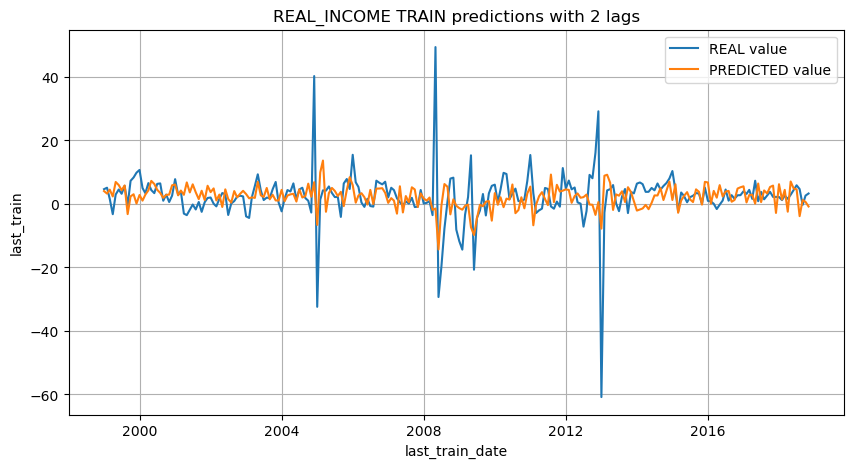

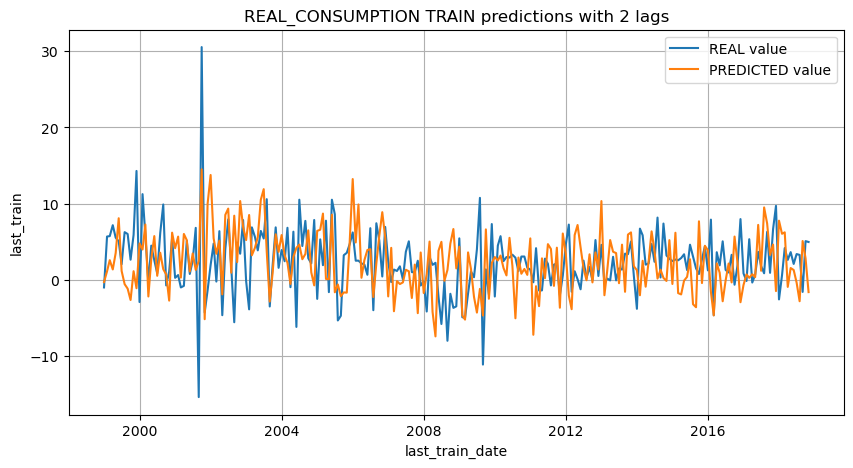

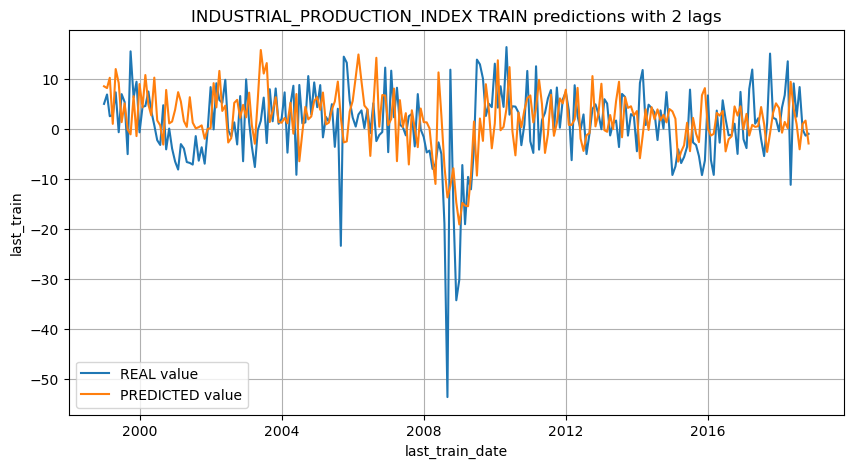

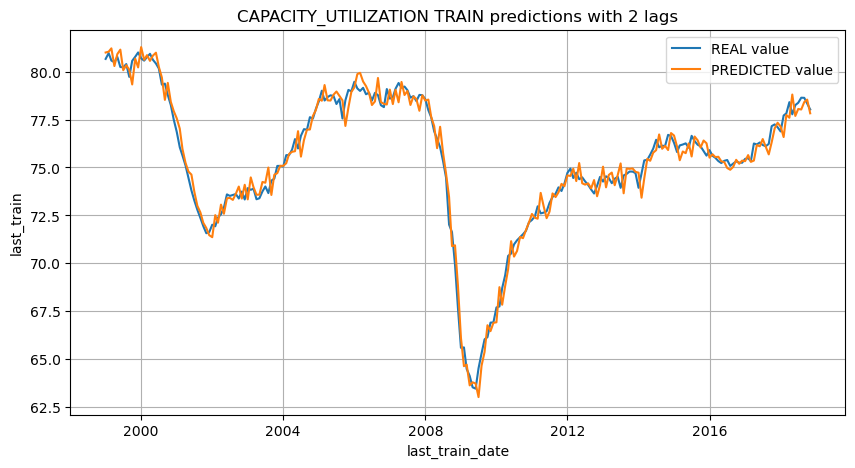

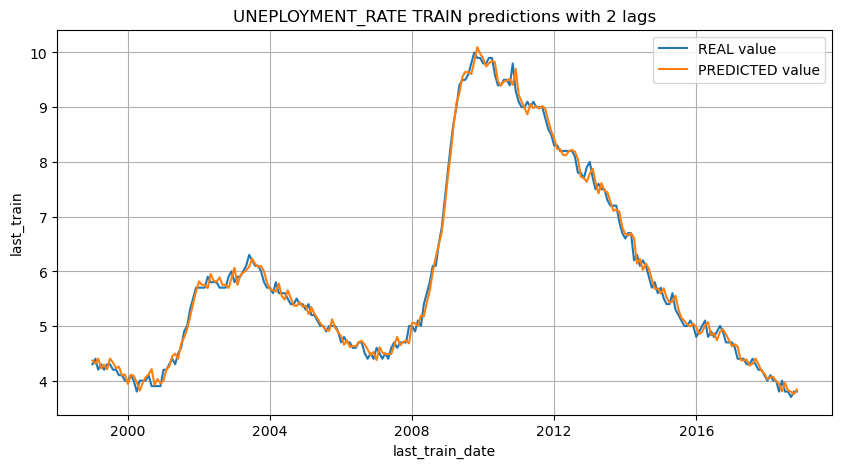

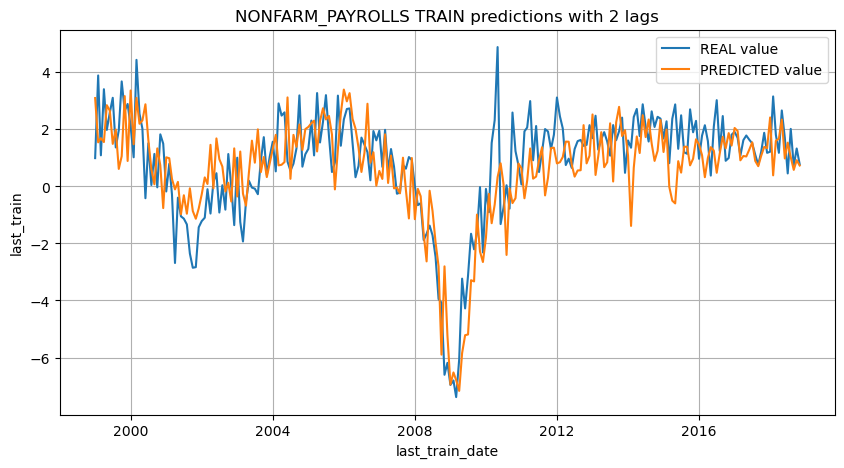

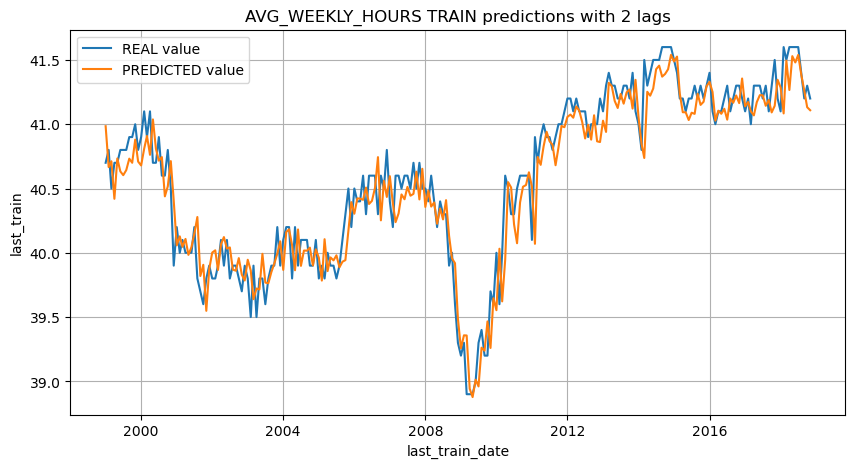

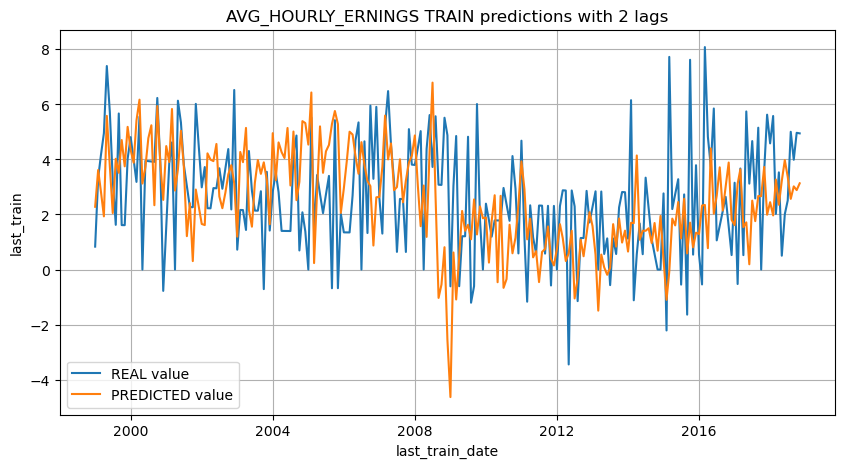

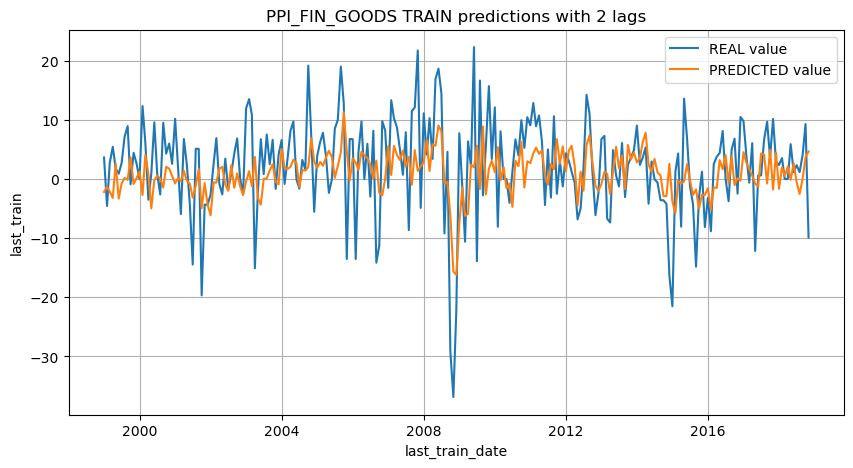

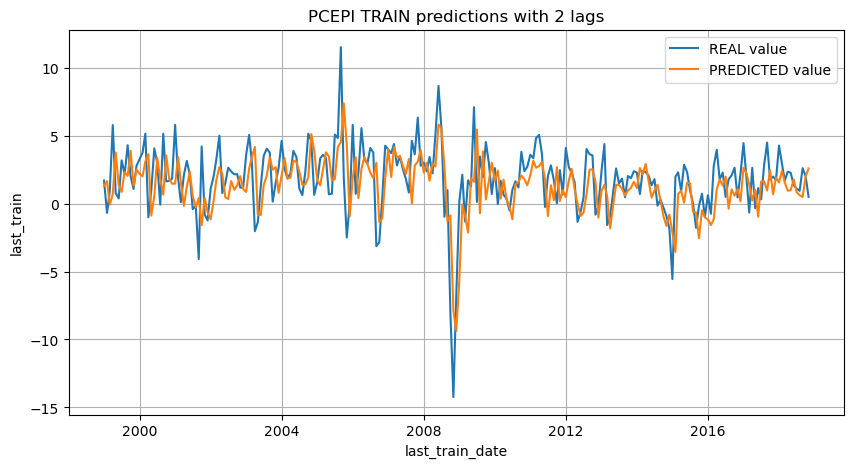

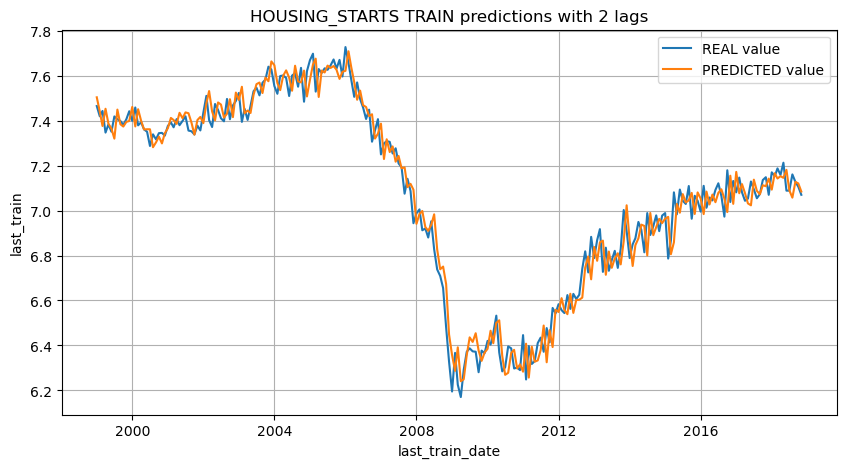

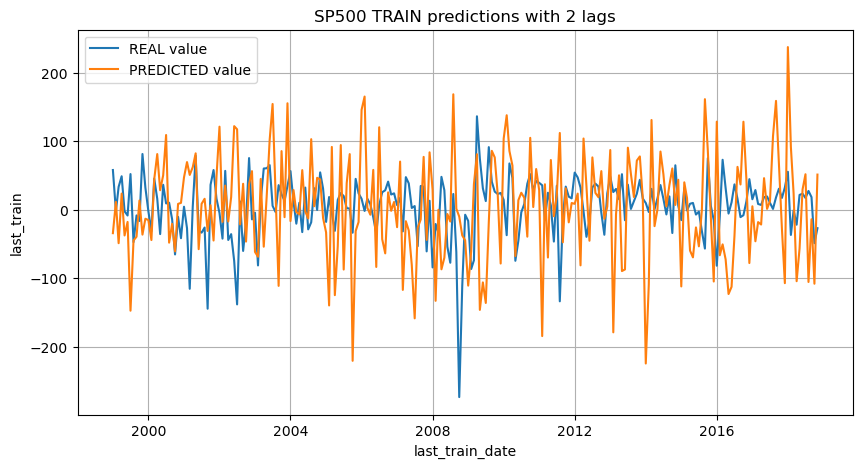

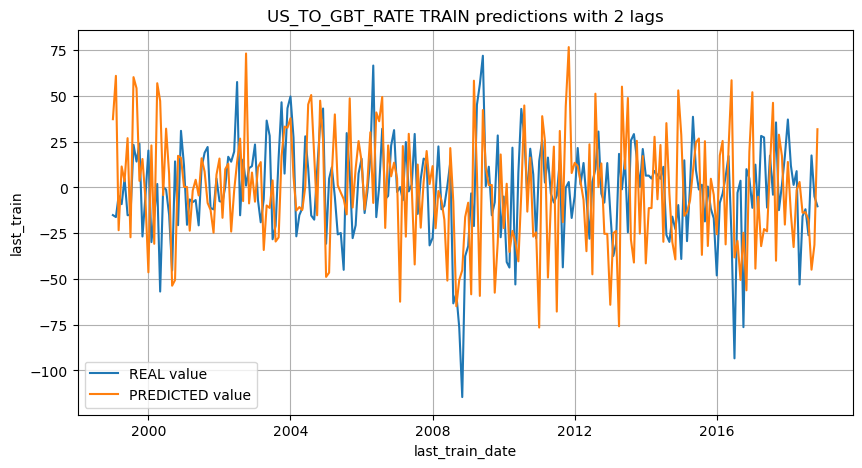

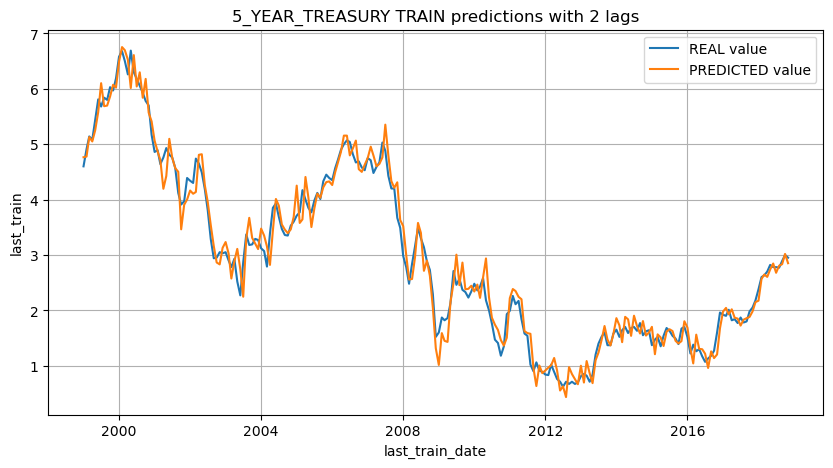

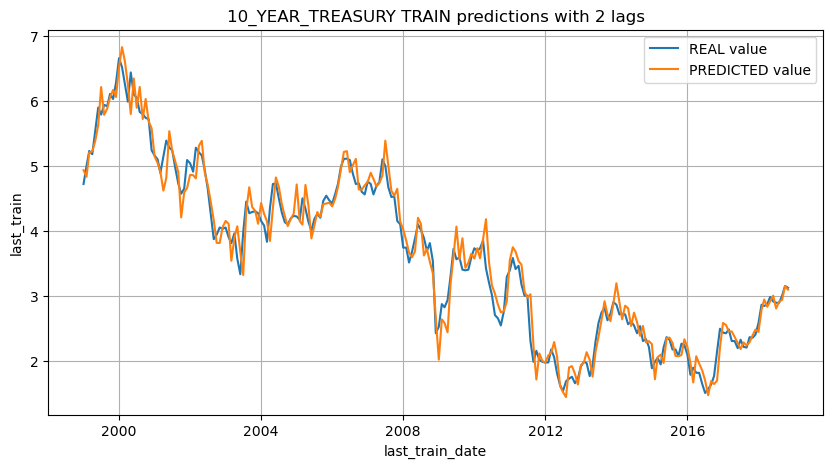

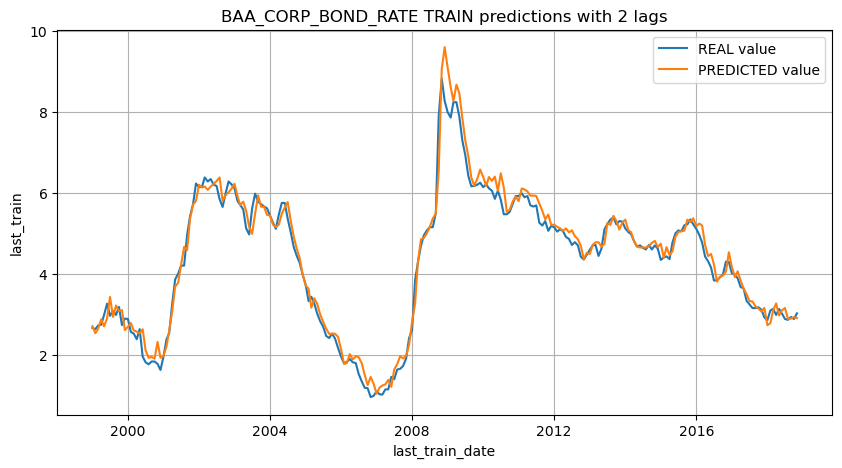

In [14]:
for f in data.columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.grid()
    sns.lineplot(x=results[f]["last_train_date"], y=results[f]["last_train"], label="REAL value");
    sns.lineplot(x=results[f]["last_train_date"], y=results[f]["train_pred"], label="PREDICTED value");
    plt.title(f"{f.upper()} TRAIN predictions with {p} lags");

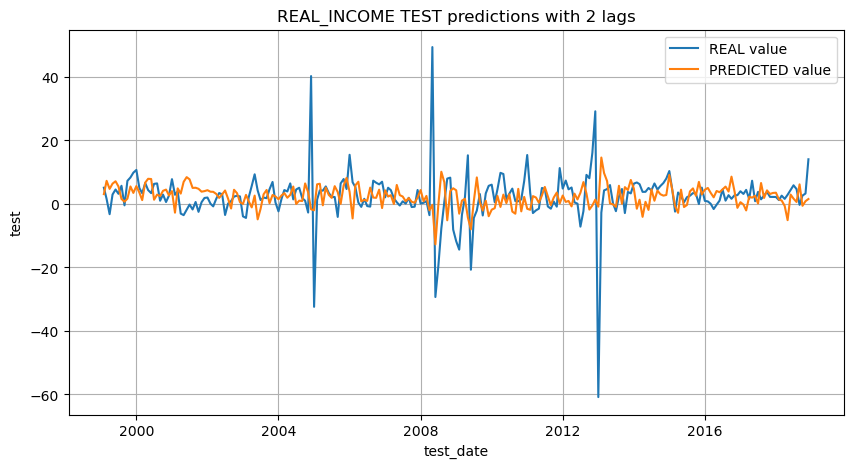

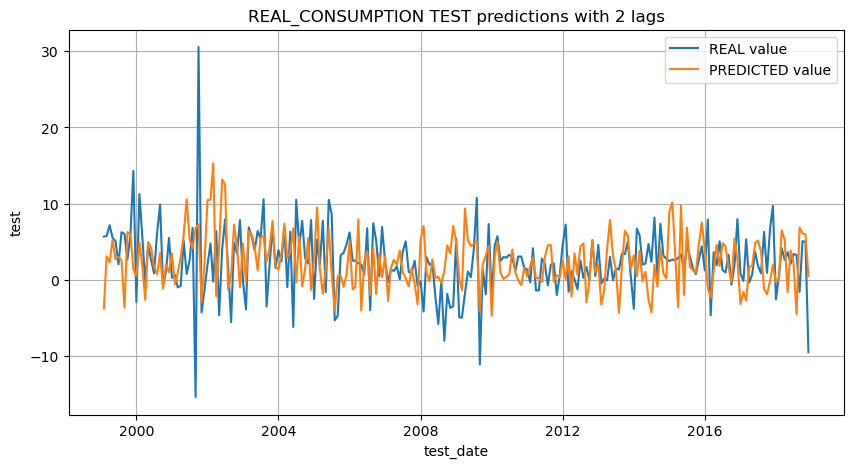

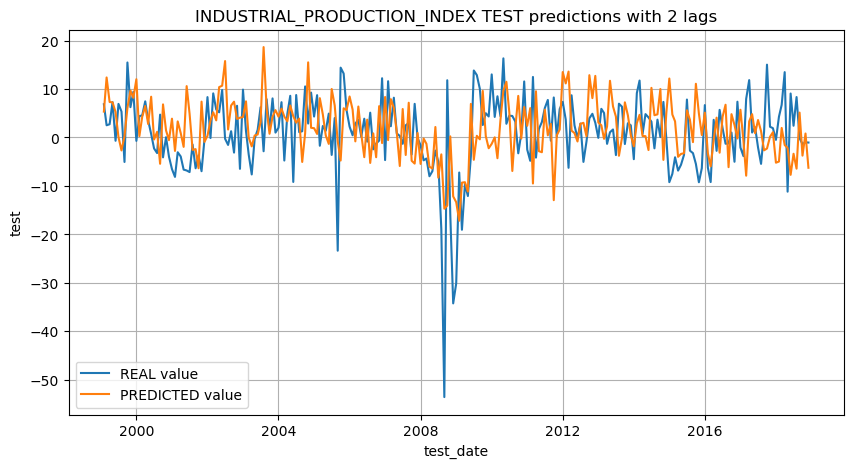

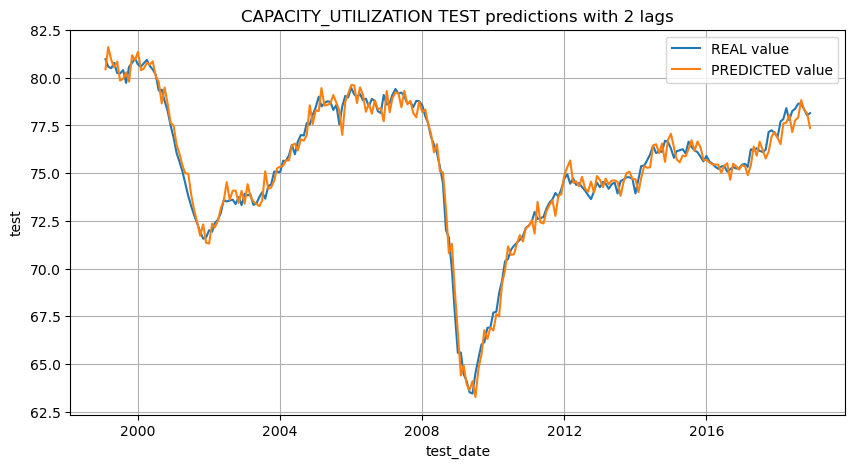

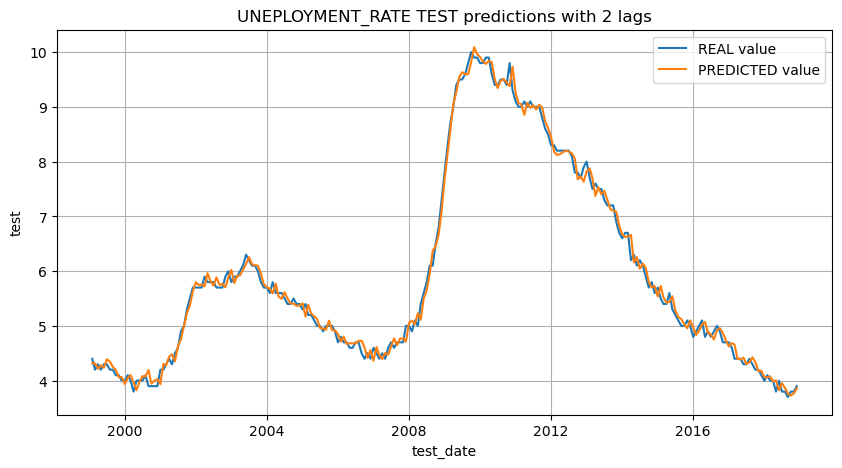

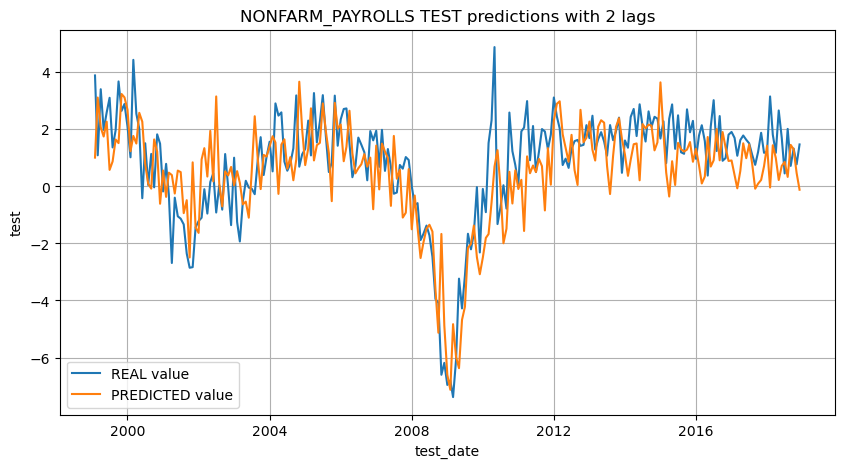

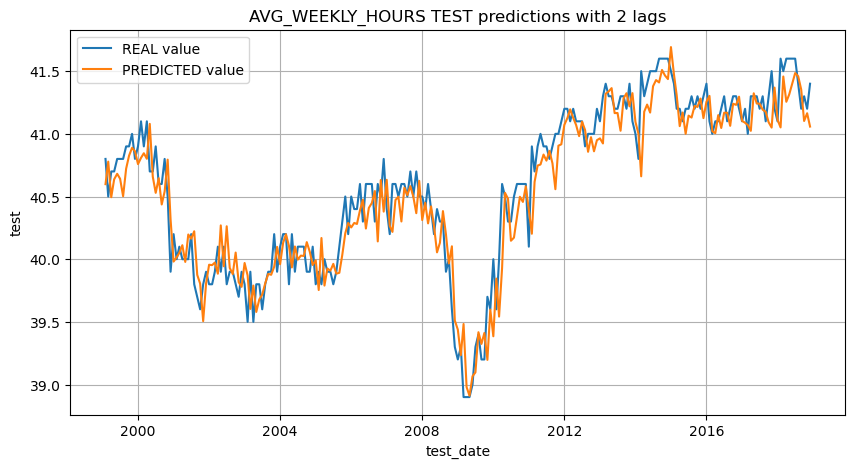

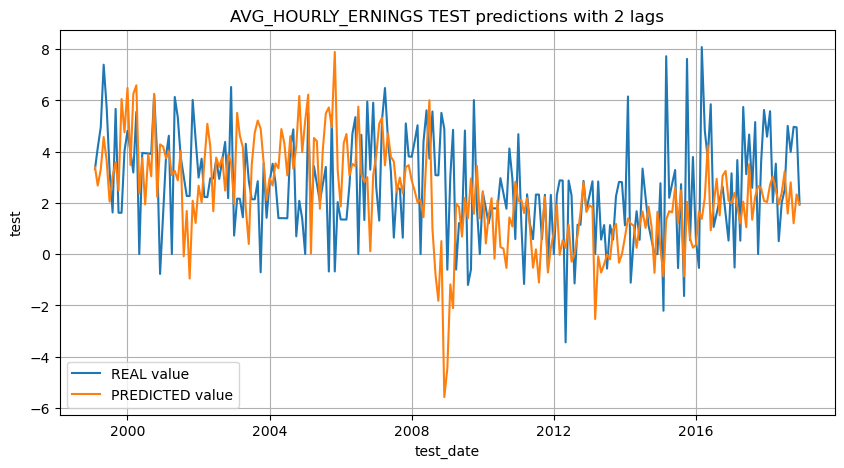

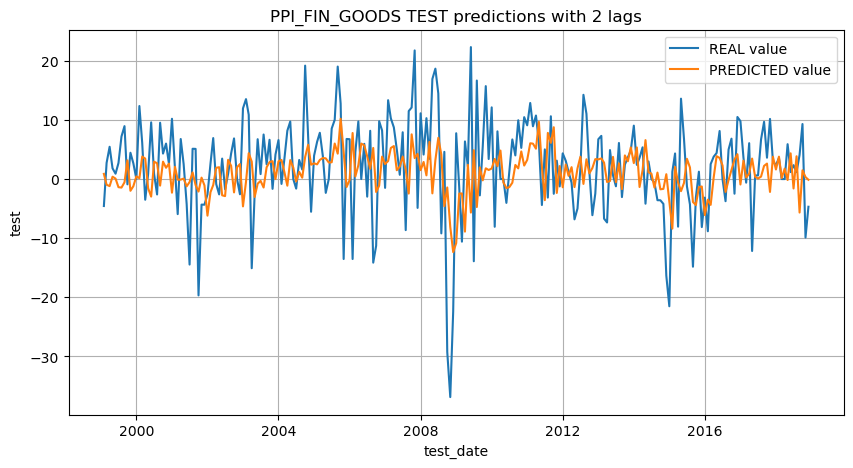

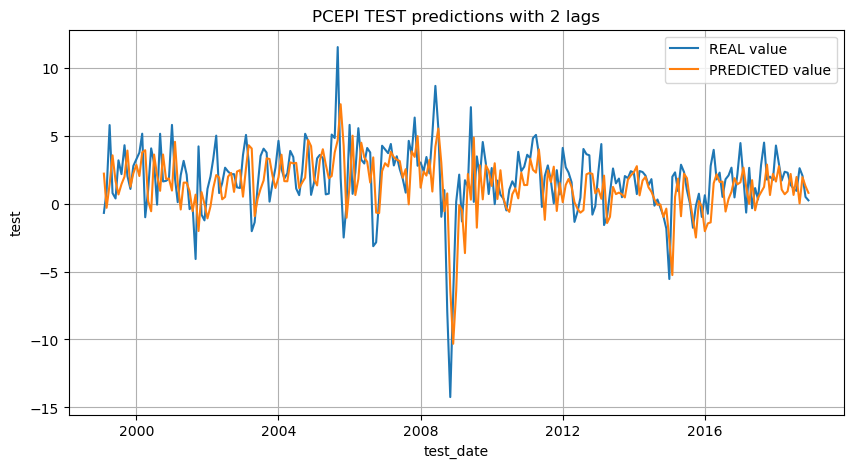

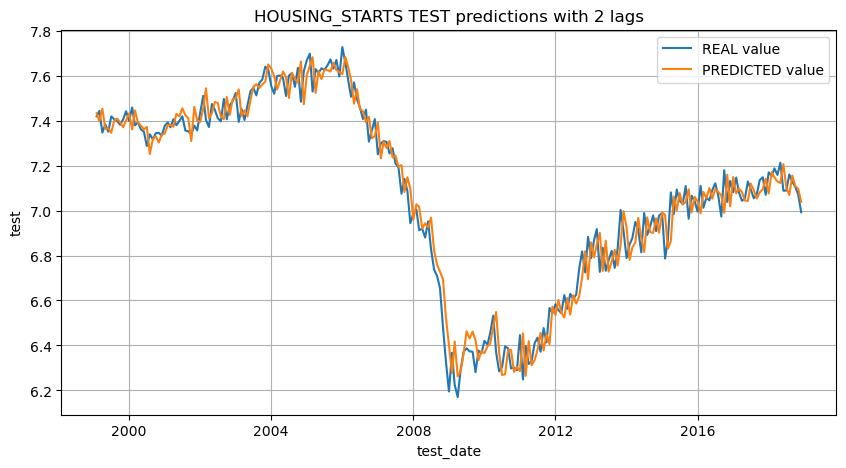

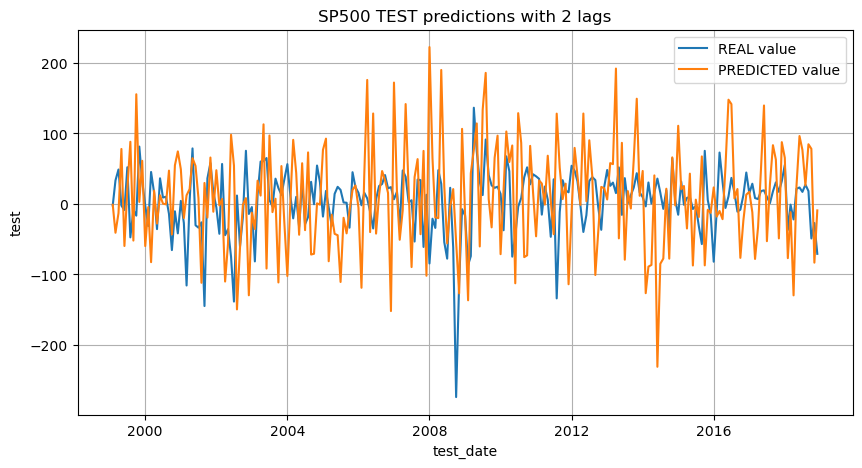

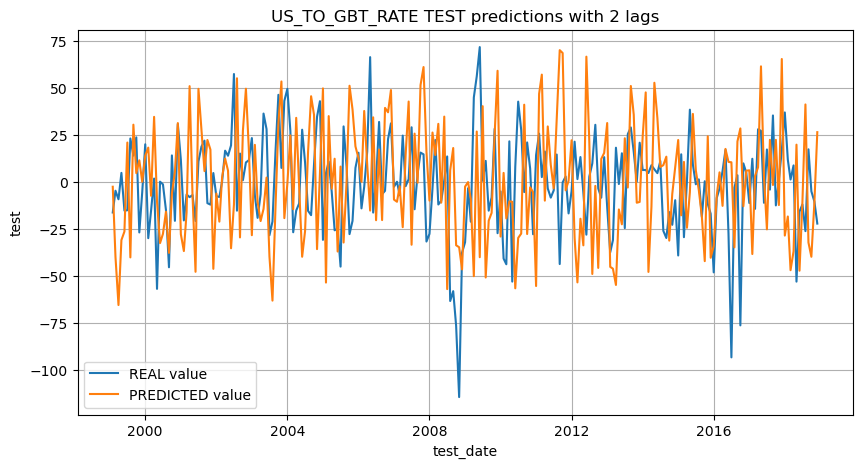

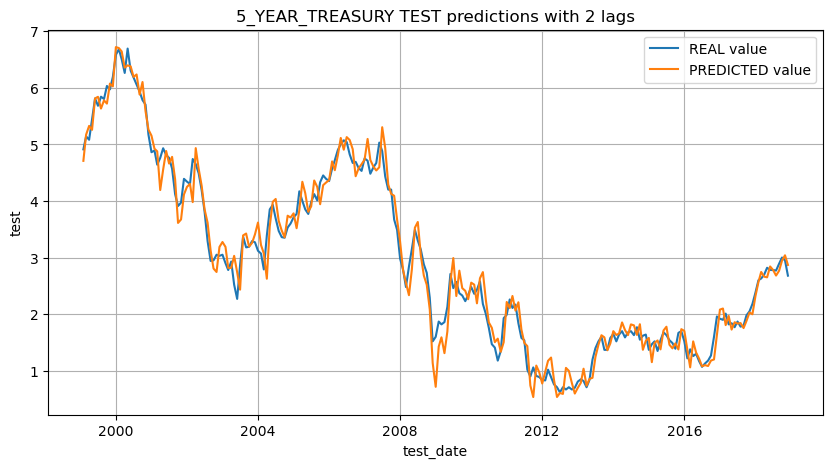

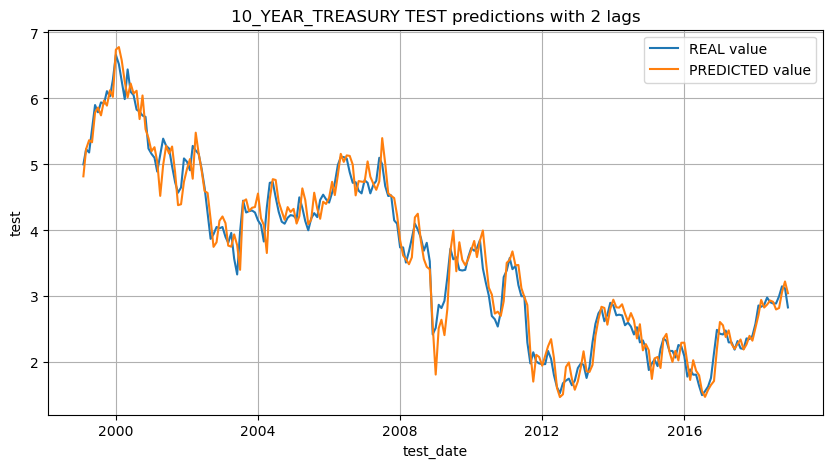

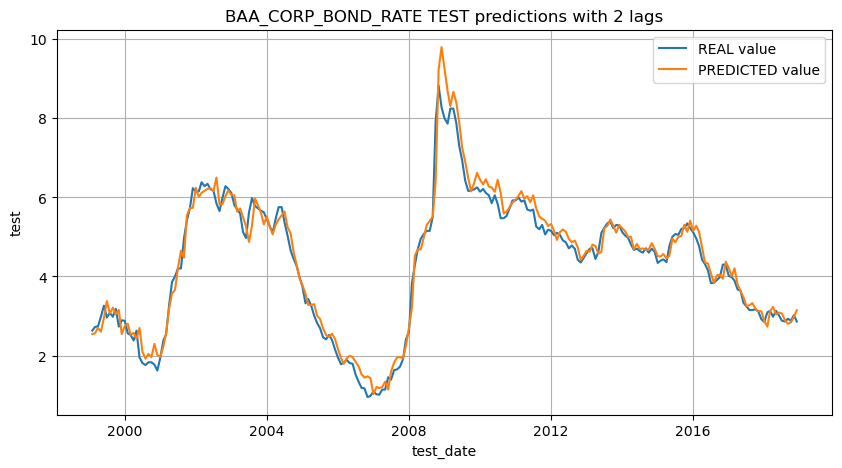

In [15]:
for f in data.columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.grid()
    sns.lineplot(x=results[f]["test_date"], y=results[f]["test"], label="REAL value");
    sns.lineplot(x=results[f]["test_date"], y=results[f]["test_pred"], label="PREDICTED value");
    plt.title(f"{f.upper()} TEST predictions with {p} lags");

## Future predictions

<AxesSubplot:xlabel='sasdate'>

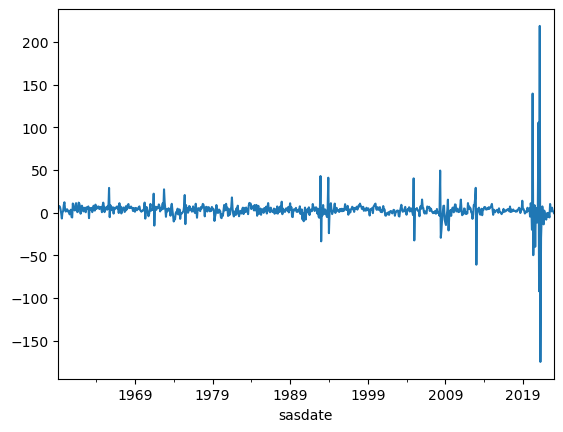

In [10]:
full_data["real_income"].plot()

In [ ]:
model = bvar.bvar(r_X_train, lags=p, n_draw=1000, n_burn=400, verbose=False, priors=priors)
test_forecast = bvar.predict_bvar(model, horizon=1, conf_bands=0.5)